In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from scipy.optimize import curve_fit

# =========================================================
# 1. Load Data and Define Functions
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from scipy.optimize import curve_fit

# =========================================================
# 1. Load Data and Define Functions
# =========================================================
def load_subset_data(filename):
    """Load RA/DEC from FITS file."""
    with fits.open(filename) as hdulist:
        data = hdulist[1].data
        ra = data['RA']
        dec = data['DEC']
    return ra, dec

def compute_acf(ra_data_rad, dec_data_rad, ra_rand_rad, dec_rand_rad, theta_bins, n_data, n_rand):
    """Compute ACF for a given dataset."""
    # Pair counts
    DD = DDtheta_mocks(
        autocorr=1, nthreads=4, binfile=theta_bins,
        RA1=ra_data_rad, DEC1=dec_data_rad,
        RA2=ra_data_rad, DEC2=dec_data_rad
    )
    DR = DDtheta_mocks(
        autocorr=0, nthreads=4, binfile=theta_bins,
        RA1=ra_data_rad, DEC1=dec_data_rad,
        RA2=ra_rand_rad, DEC2=dec_rand_rad
    )
    RR = DDtheta_mocks(
        autocorr=1, nthreads=4, binfile=theta_bins,
        RA1=ra_rand_rad, DEC1=dec_rand_rad,
        RA2=ra_rand_rad, DEC2=dec_rand_rad
    )
    
    # Normalize pair counts
    dd, dr, rr = DD['npairs'], DR['npairs'], RR['npairs']
    dd_norm = n_data * (n_data - 1) / 2
    dr_norm = n_data * n_rand
    rr_norm = n_rand * (n_rand - 1) / 2
    dd_normalized = dd / dd_norm
    dr_normalized = dr / dr_norm
    rr_normalized = rr / rr_norm
    
    # Compute w(theta)
    with np.errstate(divide='ignore', invalid='ignore'):
        w_theta = (dd_normalized - 2 * dr_normalized + rr_normalized) / rr_normalized
    
    return w_theta

def bootstrap_errors(ra_data, dec_data, ra_rand, dec_rand, theta_bins, n_bootstrap=100):
    """Compute bootstrap errors for parameters A and δ, plus errors for each w(θ) bin."""
    params_bootstrap = []
    w_bootstrap_values = []  # Store w(θ) values for each bootstrap iteration
    
    n_data = len(ra_data)
    n_rand = len(ra_rand)
    ra_rand_rad = np.radians(ra_rand)
    dec_rand_rad = np.radians(dec_rand)
    
    for i in range(n_bootstrap):
        # Resample data with replacement
        indices = np.random.choice(n_data, n_data, replace=True)
        ra_boot = ra_data[indices]
        dec_boot = dec_data[indices]
        ra_boot_rad = np.radians(ra_boot)
        dec_boot_rad = np.radians(dec_boot)
        
        try:
            # Compute ACF for this bootstrap sample
            w_boot = compute_acf(ra_boot_rad, dec_boot_rad, ra_rand_rad, dec_rand_rad, theta_bins, n_data, n_rand)
            w_bootstrap_values.append(w_boot)  # Store the full w(θ) array
            
            # Still do the parameter fitting for each bootstrap sample
            valid_mask_boot = (w_boot > -1.0) & (w_boot < 10.0) & np.isfinite(w_boot)
            theta_valid_boot = theta_centers[valid_mask_boot]
            w_valid_boot = w_boot[valid_mask_boot]
            
            if len(theta_valid_boot) > 2:
                log_theta = np.log10(theta_valid_boot)
                log_w = np.log10(w_valid_boot)
                coeffs = np.polyfit(log_theta, log_w, 1)
                p0_initial = [10**coeffs[1], -coeffs[0]]
                
                popt_b, _ = curve_fit(
                    power_law, 
                    theta_valid_boot, 
                    w_valid_boot, 
                    p0=p0_initial,
                    bounds=([0.01, 0.01], [100., 2.0]))
                params_bootstrap.append(popt_b)
        except:
            continue
    
    # Convert to numpy array for easier calculations
    params_bootstrap = np.array(params_bootstrap)
    w_bootstrap_values = np.array(w_bootstrap_values)
    
    # Calculate parameter errors
    if len(params_bootstrap) == 0:
        A_std_bs, delta_std_bs = np.nan, np.nan
    else:
        A_std_bs = np.std(params_bootstrap[:, 0], ddof=1)
        delta_std_bs = np.std(params_bootstrap[:, 1], ddof=1)
    
    # Calculate w(θ) errors for each bin
    if len(w_bootstrap_values) == 0:
        w_errors = np.full(len(theta_centers), np.nan)
    else:
        w_errors = np.std(w_bootstrap_values, axis=0, ddof=1)
    
    return A_std_bs, delta_std_bs, w_errors

def power_law(theta, A, delta):
    return A * theta**(-delta)


In [2]:
# =========================================================
# 2. Main Workflow
# =========================================================
# Load data
ra_data, dec_data = load_subset_data('north_subset.fits')

# Generate random catalog
n_data = len(ra_data)
n_rand = 50 * n_data
ra_min, ra_max = np.min(ra_data), np.max(ra_data)
dec_min, dec_max = np.min(dec_data), np.max(dec_data)
ra_rand = np.random.uniform(ra_min, ra_max, n_rand)
dec_rand = np.random.uniform(dec_min, dec_max, n_rand)

# Angular bins (coarser to reduce noise)
theta_bins = np.logspace(-2., 2, 100)  # 0.1 to 100 degrees
theta_centers = 0.5 * (theta_bins[1:] + theta_bins[:-1])

# Compute original ACF
ra_data_rad = np.radians(ra_data)
dec_data_rad = np.radians(dec_data)
ra_rand_rad = np.radians(ra_rand)
dec_rand_rad = np.radians(dec_rand)
w_theta = compute_acf(ra_data_rad, dec_data_rad, ra_rand_rad, dec_rand_rad, theta_bins, n_data, n_rand)

# Mask invalid bins
valid_mask = (w_theta > -1.0) & (w_theta < 10.0) & np.isfinite(w_theta)
theta_valid = theta_centers[valid_mask]
w_valid = w_theta[valid_mask]

# Estimate initial parameters from data
log_theta = np.log10(theta_valid)
log_w = np.log10(w_valid)
coeffs = np.polyfit(log_theta, log_w, 1)
p0_initial = [10**coeffs[1], -coeffs[0]]  # w ~ Aθ^-δ → log(w) = log(A) - δ*log(θ)

# Fit power law with bounds
try:
    popt, pcov = curve_fit(
        power_law, 
        theta_valid, 
        w_valid, 
        p0=p0_initial,
        bounds=([0.01, 0.01], [100., 2.0]))
    A_fit, delta_fit = popt
    A_err, delta_err = np.sqrt(np.diag(pcov))
except Exception as e:
    print(f"Fit failed: {e}")
    A_fit, delta_fit = p0_initial
    A_err, delta_err = np.nan, np.nan

# Compute bootstrap errors for parameters and w(θ)
A_std_bs, delta_std_bs, w_errors = bootstrap_errors(ra_data, dec_data, ra_rand, dec_rand, theta_bins, n_bootstrap=100)

print(f"Fit (Covariance Errors): A = {A_fit:.3f} ± {A_err:.3f}, δ = {delta_fit:.3f} ± {delta_err:.3f}")
print(f"Fit (Bootstrap Errors): A = {A_fit:.3f} ± {A_std_bs:.3f}, δ = {delta_fit:.3f} ± {delta_std_bs:.3f}")

Fit (Covariance Errors): A = 0.735 ± 0.047, δ = 0.102 ± 0.019
Fit (Bootstrap Errors): A = 0.735 ± 0.063, δ = 0.102 ± 0.033


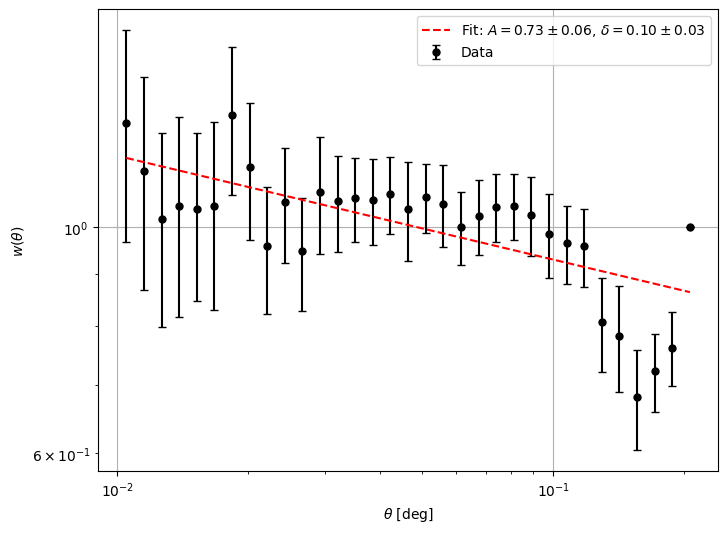

In [3]:
# =========================================================
# 3. Plot Results
# =========================================================
plt.figure(figsize=(8, 6))
# Add Maddox+90 power law for comparison
# Maddox+90 parameters (adjust these to the exact values from the paper)
A_maddox = 1  # actual value from paper
delta_maddox = 0.7  # actual value from paper

# Add to your plot
#plt.plot(theta_fine, power_law(theta_fine, A_maddox, delta_maddox), 'b-.',
        # label=f'Maddox+90: A={A_maddox:.2f}, δ={delta_maddox:.2f}')
#plt.legend()
# Use the bootstrap-derived errors for each bin
plt.errorbar(theta_valid, w_valid, yerr=w_errors[valid_mask], fmt='o', color='k', 
             markersize=5, label='Data', capsize=3)

theta_fine = np.logspace(np.log10(theta_valid.min()), np.log10(theta_valid.max()), 100)
plt.plot(theta_fine, power_law(theta_fine, A_fit, delta_fit), 'r--',
         label=fr'Fit: $A={A_fit:.2f} \pm {A_std_bs:.2f}$, $\delta={delta_fit:.2f} \pm {delta_std_bs:.2f}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$w(\theta)$')
plt.legend()
plt.grid()
plt.savefig('acf_with_errors_fixed.png', dpi=300)
plt.show()

In [4]:
# =========================================================
# 2. Main Workflow
# =========================================================
# Load data
ra_data, dec_data = load_subset_data('north_subset.fits')

# Generate random catalog
n_data = len(ra_data)
n_rand = 50 * n_data
ra_min, ra_max = np.min(ra_data), np.max(ra_data)
dec_min, dec_max = np.min(dec_data), np.max(dec_data)
ra_rand = np.random.uniform(ra_min, ra_max, n_rand)
dec_rand = np.random.uniform(dec_min, dec_max, n_rand)

# Angular bins (coarser to reduce noise)
theta_bins = np.logspace(-1., 2, 100)  # 0.1 to 100 degrees
theta_centers = (theta_bins[1:] + theta_bins[:-1]) / 2

# Compute original ACF
ra_data_rad = np.radians(ra_data)
dec_data_rad = np.radians(dec_data)
ra_rand_rad = np.radians(ra_rand)
dec_rand_rad = np.radians(dec_rand)
w_theta = compute_acf(ra_data_rad, dec_data_rad, ra_rand_rad, dec_rand_rad, theta_bins, n_data, n_rand)

# Mask invalid bins
valid_mask = (w_theta > -1.0) & (w_theta < 10.0) & np.isfinite(w_theta)
theta_valid = theta_centers[valid_mask]
w_valid = w_theta[valid_mask]

# Estimate initial parameters from data
log_theta = np.log10(theta_valid)
log_w = np.log10(w_valid)
coeffs = np.polyfit(log_theta, log_w, 1)
p0_initial = [10**coeffs[1], -coeffs[0]]  # w ~ Aθ^-δ → log(w) = log(A) - δ*log(θ)

# Fit power law with bounds
try:
    popt, pcov = curve_fit(
        power_law, 
        theta_valid, 
        w_valid, 
        p0=p0_initial,
        bounds=([0.01, 0.01], [100., 2.0]))
    A_fit, delta_fit = popt
    A_err, delta_err = np.sqrt(np.diag(pcov))
except Exception as e:
    print(f"Fit failed: {e}")
    A_fit, delta_fit = p0_initial
    A_err, delta_err = np.nan, np.nan

# Compute bootstrap errors for parameters and w(θ)
A_std_bs, delta_std_bs, w_errors = bootstrap_errors(ra_data, dec_data, ra_rand, dec_rand, theta_bins, n_bootstrap=100)

print(f"Fit (Covariance Errors): A = {A_fit:.3f} ± {A_err:.3f}, δ = {delta_fit:.3f} ± {delta_err:.3f}")
print(f"Fit (Bootstrap Errors): A = {A_fit:.3f} ± {A_std_bs:.3f}, δ = {delta_fit:.3f} ± {delta_std_bs:.3f}")

Fit (Covariance Errors): A = 0.438 ± 0.176, δ = 0.342 ± 0.205
Fit (Bootstrap Errors): A = 0.438 ± 0.151, δ = 0.342 ± 0.197


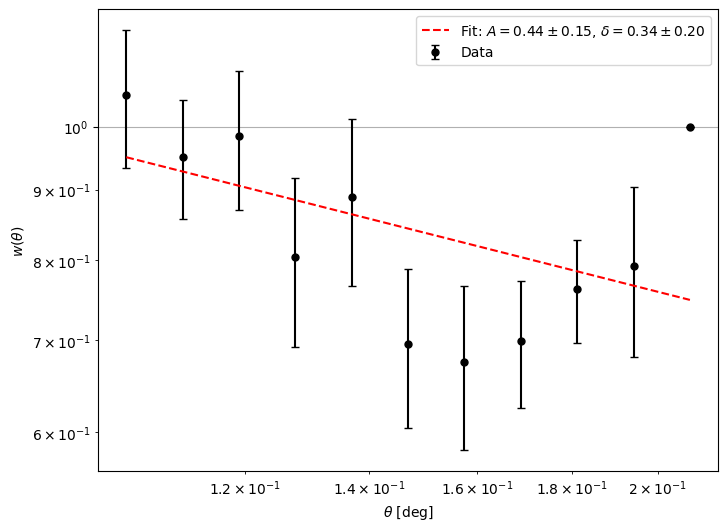

In [5]:
# =========================================================
# 3. Plot Results
# =========================================================
plt.figure(figsize=(8, 6))
# Add Maddox+90 power law for comparison
# Maddox+90 parameters
A_maddox = 1  # actual value from paper
delta_maddox = 0.7  
# Add to your plot
#plt.plot(theta_fine, power_law(theta_fine, A_maddox, delta_maddox), 'b-.',
        # label=f'Maddox+90: A={A_maddox:.2f}, δ={delta_maddox:.2f}')
#plt.legend()
# Use the bootstrap-derived errors for each bin
plt.errorbar(theta_valid, w_valid, yerr=w_errors[valid_mask], fmt='o', color='k', 
             markersize=5, label='Data', capsize=3)

theta_fine = np.logspace(np.log10(theta_valid.min()), np.log10(theta_valid.max()), 100)
plt.plot(theta_fine, power_law(theta_fine, A_fit, delta_fit), 'r--',
         label=fr'Fit: $A={A_fit:.2f} \pm {A_std_bs:.2f}$, $\delta={delta_fit:.2f} \pm {delta_std_bs:.2f}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$w(\theta)$')
plt.legend()
plt.grid()
plt.savefig('acf_with_errors_fixed.png', dpi=300)
plt.show()

In [6]:
# =========================================================
# 2. Main Workflow
# =========================================================
# Load data
ra_data, dec_data = load_subset_data('north_subset.fits')

# Generate random catalog
n_data = len(ra_data)
n_rand = 50 * n_data
ra_min, ra_max = np.min(ra_data), np.max(ra_data)
dec_min, dec_max = np.min(dec_data), np.max(dec_data)
ra_rand = np.random.uniform(ra_min, ra_max, n_rand)
dec_rand = np.random.uniform(dec_min, dec_max, n_rand)

# Angular bins (coarser to reduce noise)
theta_bins = np.logspace(-1., 1, 100)  # 0.1 to 100 degrees
theta_centers = (theta_bins[1:] + theta_bins[:-1]) / 2

# Compute original ACF
ra_data_rad = np.radians(ra_data)
dec_data_rad = np.radians(dec_data)
ra_rand_rad = np.radians(ra_rand)
dec_rand_rad = np.radians(dec_rand)
w_theta = compute_acf(ra_data_rad, dec_data_rad, ra_rand_rad, dec_rand_rad, theta_bins, n_data, n_rand)

# Mask invalid bins
valid_mask = (w_theta > -1.0) & (w_theta < 10.0) & np.isfinite(w_theta)
theta_valid = theta_centers[valid_mask]
w_valid = w_theta[valid_mask]

# Estimate initial parameters from data
log_theta = np.log10(theta_valid)
log_w = np.log10(w_valid)
coeffs = np.polyfit(log_theta, log_w, 1)
p0_initial = [10**coeffs[1], -coeffs[0]]  # w ~ Aθ^-δ → log(w) = log(A) - δ*log(θ)

# Fit power law with bounds
try:
    popt, pcov = curve_fit(
        power_law, 
        theta_valid, 
        w_valid, 
        p0=p0_initial,
        bounds=([0.01, 0.01], [100., 2.0]))
    A_fit, delta_fit = popt
    A_err, delta_err = np.sqrt(np.diag(pcov))
except Exception as e:
    print(f"Fit failed: {e}")
    A_fit, delta_fit = p0_initial
    A_err, delta_err = np.nan, np.nan

# Compute bootstrap errors for parameters and w(θ)
A_std_bs, delta_std_bs, w_errors = bootstrap_errors(ra_data, dec_data, ra_rand, dec_rand, theta_bins, n_bootstrap=100)

print(f"Fit (Covariance Errors): A = {A_fit:.3f} ± {A_err:.3f}, δ = {delta_fit:.3f} ± {delta_err:.3f}")
print(f"Fit (Bootstrap Errors): A = {A_fit:.3f} ± {A_std_bs:.3f}, δ = {delta_fit:.3f} ± {delta_std_bs:.3f}")

Fit (Covariance Errors): A = 0.416 ± 0.131, δ = 0.363 ± 0.159
Fit (Bootstrap Errors): A = 0.416 ± 0.136, δ = 0.363 ± 0.181


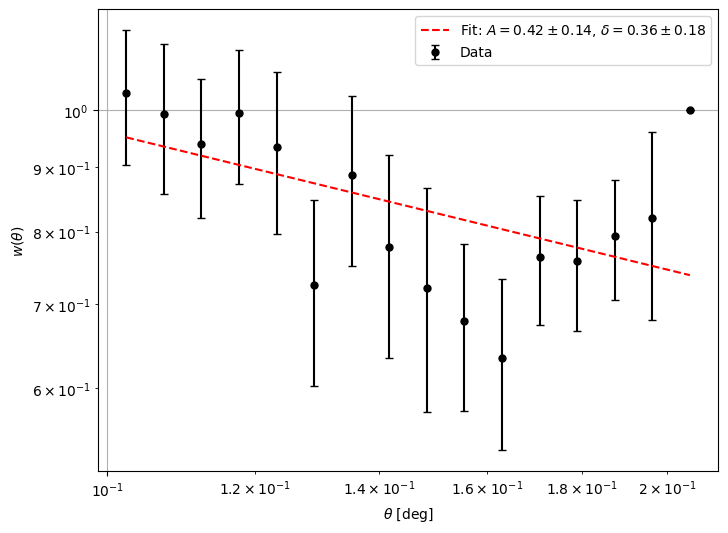

In [7]:
# =========================================================
# 3. Plot Results
# =========================================================
plt.figure(figsize=(8, 6))
# Add Maddox+90 power law for comparison
# Maddox+90 parameters (adjust these to the exact values from the paper)
A_maddox = 1  # actual value from paper
delta_maddox = 0.7  #  use actual value from paper

# Add to  plot
#plt.plot(theta_fine, power_law(theta_fine, A_maddox, delta_maddox), 'b-.',
        # label=f'Maddox+90: A={A_maddox:.2f}, δ={delta_maddox:.2f}')
#plt.legend()
# Use the bootstrap-derived errors for each bin
plt.errorbar(theta_valid, w_valid, yerr=w_errors[valid_mask], fmt='o', color='k', 
             markersize=5, label='Data', capsize=3)

theta_fine = np.logspace(np.log10(theta_valid.min()), np.log10(theta_valid.max()), 100)
plt.plot(theta_fine, power_law(theta_fine, A_fit, delta_fit), 'r--',
         label=fr'Fit: $A={A_fit:.2f} \pm {A_std_bs:.2f}$, $\delta={delta_fit:.2f} \pm {delta_std_bs:.2f}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$w(\theta)$')
plt.legend()
plt.grid()
plt.savefig('acf_with_errors_fixed.png', dpi=300)
plt.show()